In [1]:
# Segmentation client e-commerce

# 1️⃣ Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os

In [2]:
# 2Create output folders if they don't exist
os.makedirs("outputs/figures", exist_ok=True)

In [3]:
# 2️⃣ Chargement du dataset
# Dataset Kaggle : https://www.kaggle.com/datasets/carrie1/ecommerce-data
df = pd.read_csv("/Users/benoitvuboh/Desktop/clients segmentation/data/data.csv", encoding='ISO-8859-1')
df.head

<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerI

In [4]:
# 3️⃣ Nettoyage et préparation
df.drop_duplicates(inplace=True)
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

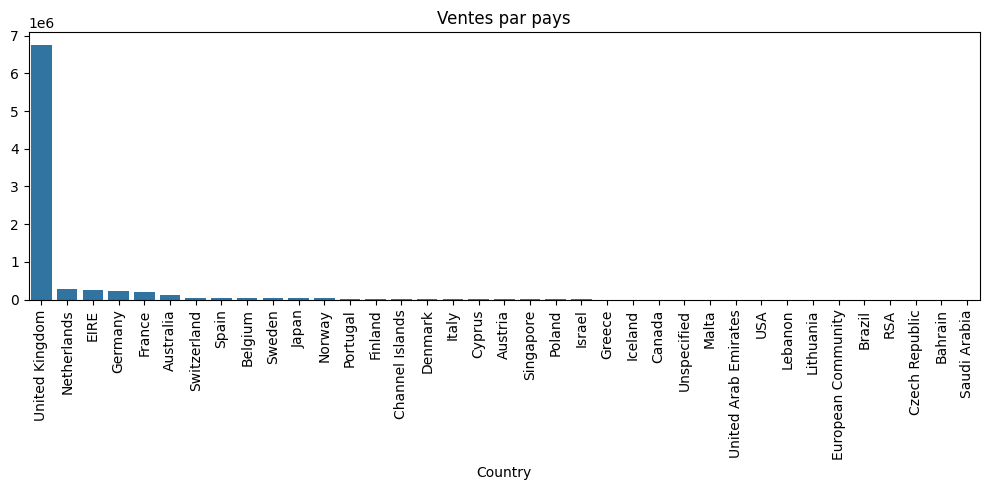

In [5]:
# 4️⃣ Analyse exploratoire
# Ventes par pays
sales_country = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=sales_country.index, y=sales_country.values)
plt.xticks(rotation=90)
plt.title("Ventes par pays")
plt.tight_layout()
plt.savefig("outputs/figures/sales_by_country.png")
plt.show()

In [6]:
# 5️⃣ RFM Segmentation
import datetime as dt
NOW = dt.datetime(2025,10,5)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'InvoiceNo': 'count',
    'TotalAmount': 'sum'
})

rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalAmount':'Monetary'}, inplace=True)

In [7]:
# Normalisation
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Clustering KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

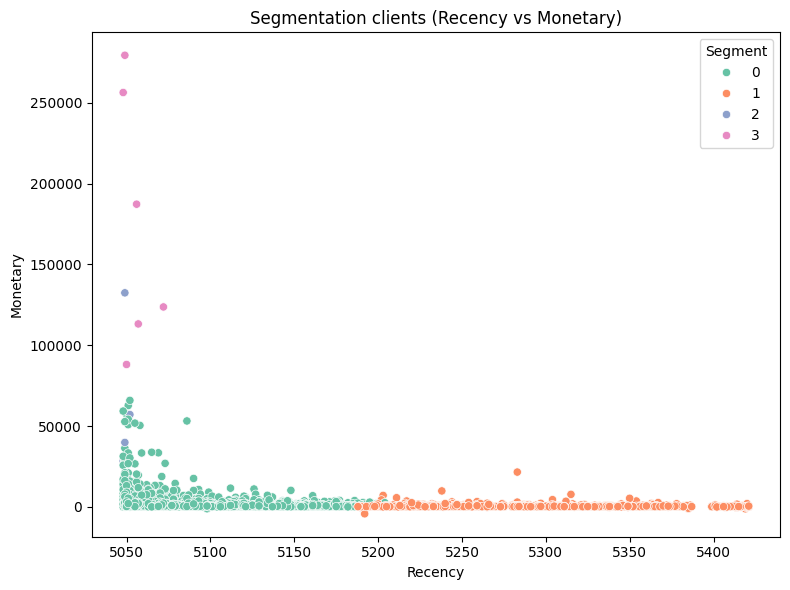

In [8]:
# Visualisation des segments
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Segment'], palette='Set2')
plt.title("Segmentation clients (Recency vs Monetary)")
plt.tight_layout()
plt.savefig("outputs/figures/rfm_segments.png")
plt.show()

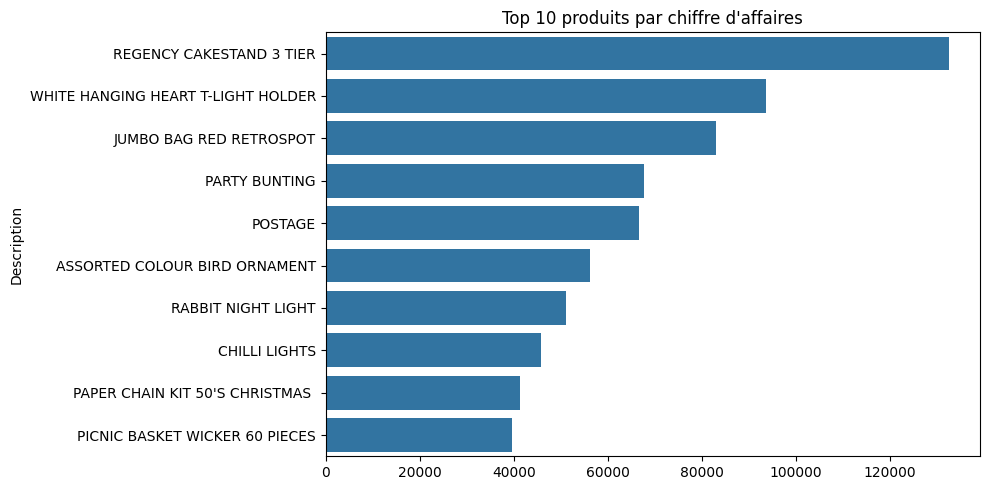

In [9]:
# 6️⃣ Analyse des produits
top_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 produits par chiffre d'affaires")
plt.tight_layout()
plt.savefig("outputs/figures/top_products.png")
plt.show()

In [10]:
# 7️⃣ Modèle prédictif simple : prédire si client achètera prochain mois
# Création d'une variable target : si le client a acheté dans le dernier mois
df['Target'] = np.where(df['InvoiceDate'] > (NOW - pd.Timedelta(days=30)), 1, 0)
customer_features = rfm[['Recency','Frequency','Monetary']]
target = df.groupby('CustomerID')['Target'].max()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(customer_features, target, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
print("Classification Report :\n", classification_report(y_test, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))

Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       875

    accuracy                           1.00       875
   macro avg       1.00      1.00      1.00       875
weighted avg       1.00      1.00      1.00       875

Confusion Matrix :
 [[875]]


/Users/benoitvuboh/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [13]:
# 8️⃣ Sauvegarde du notebook pour GitHub
rfm.to_csv("outputs/rfm_segments.csv")